In [44]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from PIL import Image
from sklearn.cluster import KMeans
from sklearn.cluster.k_means_ import _init_centroids
from sklearn.metrics import calinski_harabaz_score, davies_bouldin_score

In [45]:
import warnings
warnings.filterwarnings('ignore')

Tworzymy dataset jak w przykladzie i uruchamiamy na nim algorytm k-means z k równym 9 i następującymi metodami inicjowania środków klastrów:

* Random - z rozkładem jednostajnym po całym zakresie wartości;
* Forgy - wybieramy k elementów ze zbioru jako początkowe środki;
* Random Partition - losowo dzielimy zbiór na k klastrów, początkowy środek klastra to średnia z elementów które w ten sposób w nim się znalazły;
* k-means++ - wybieramy początkowe środki w sposób opisany w paperze z załącznika.

Naszym celem jest uzyskanie wykresu jakości klastryzacji Q w zależności od numeru iteracji n dla wszystkich powyższych metod (wszystkie wyniki na jednym wykresie). Jakość Q rozumiemy jako wybraną metrykę jakości (np. Davies-Bouldin index czy Dunn index, może być dowolna rozsądna inna - ale nie Silhouette). Proces k-means jest silnie stochastyczny, więc eksperyment powtarzamy wielokrotnie, a na wykresie pokazujemy średni wynik i jego odchylenie standardowe jako errorbary.

In [46]:
data = ('kmeans-data/data-normal.png', 'kmeans-data/data-damaged.png')
output_paths = ('kmeans-data/kmeans-dataset-normal.csv', 'kmeans-data/kmeans-dataset-deamged.csv')

In [47]:
%matplotlib inline
def show_data(img_path):
    pil_im = Image.open(img_path, 'r')
    plt.imshow(np.asarray(pil_im))

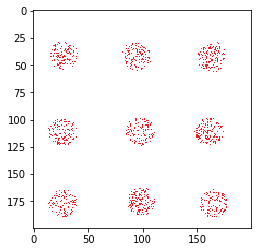

In [48]:
show_data(data[0])

Jak w poprzednich zadanich zrzucam dane do formatu csv, aby latwo pozniej z nich skorzystac w przyszlosci/innym zadaniu

In [49]:
def noise(point: float):
    return point + round(random.gauss(0, 1), 4)

def write_data_to_csv(source_img: str, dest_path: str):
    """
    Save given k-means image to csv-like format.
    Csv file contains 2 columns: x co-ordinate, y co-ordinate
    """
    image = Image.open(source_img)
    width, height = image.size
    with open(dest_path, 'w') as dest_file:
        for x in range(0, width):
            for y in range(0, height):
                pixel_color: tuple = image.getpixel((x,y))[:3]
                if pixel_color != (255, 255, 255):
                    dest_file.write(f'{noise(x)};{noise(y)}\n')

In [50]:
write_data_to_csv(data[0], output_paths[0])

In [51]:
X = pd.read_csv(output_paths[0], sep=';', names=['x', 'y'])
X = np.array(X)

Dane po zaczytaniu

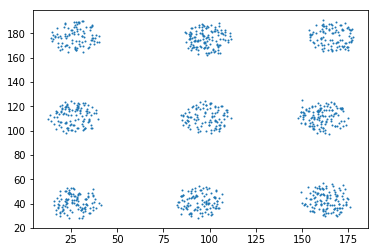

In [52]:
plt.scatter(X[:, 0], X[:, 1], s=1)
plt.show()

In [53]:
"""All init method are set up for k-means with k=9"""
init_methods = {
    'random': lambda data: np.random.rand(9,2) * (X.max(axis=0) - X.min(axis=0)) + X.min(axis=0),
    'forgy': lambda data: _init_centroids(data, 9, 'random'),
    'random_partition': lambda X: np.array([X[np.random.randint(0, 9, X.shape[0])==i].mean(axis=0) for i in range(9)]),
    'k-means++': lambda data: _init_centroids(data, 9, 'k-means++')
}

In [54]:
def kmeans_(X: np.ndarray, init_methods: dict):
    kmeans_result = []
    for name, method in init_methods.items():
        kmeans = KMeans(n_clusters=9, init=method(X), n_init=1).fit(X)
        kmeans_result.append((name, kmeans))
    return kmeans_result

kmeans_result = kmeans_(X, init_methods)

Result:

In [55]:
colors = ['#CD6155','#AF7AC5', '#5499C7', '#148F77', '#52BE80', '#F4D03F', '#EB984E', '#A6ACAF', '#F300FF']

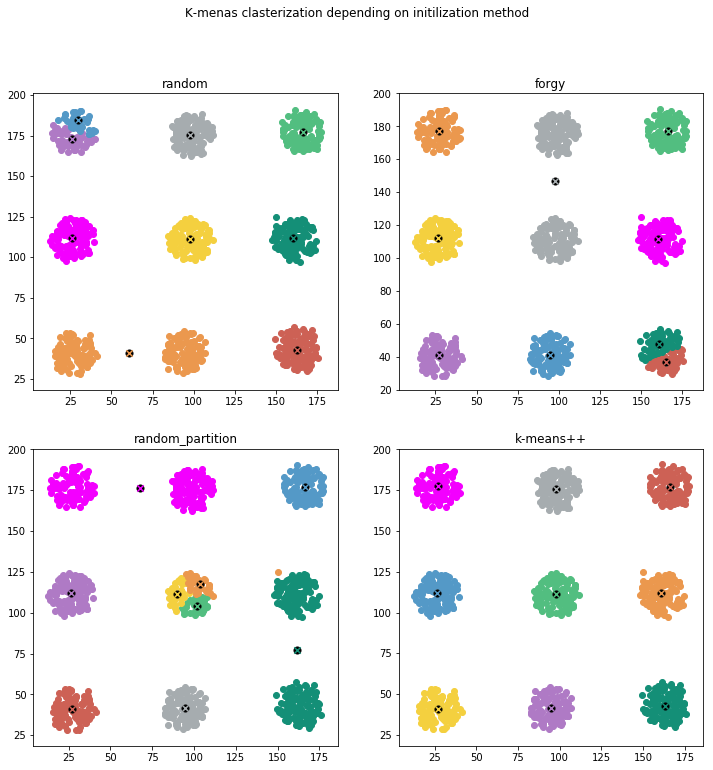

In [56]:
def plot_clusterization(X: np.ndarray, kmeans_result: tuple, colors: list):
    fig = plt.figure(figsize=(12,12))
    fig.suptitle("K-menas clasterization depending on initilization method")

    for i, (name, kmeans) in enumerate(kmeans_result):
        plt.subplot(2, 2, i+1)
        plt.title(name)

        clusters = kmeans.predict(X)
        for cluster_val, color in zip(np.unique(clusters), colors):
            X_clustered = X[clusters==cluster_val]
            p = plt.scatter(X_clustered[:, 0], X_clustered[:,1], c=color)
            centre = kmeans.cluster_centers_[cluster_val]
            plt.scatter([centre[0]], [centre[1]], marker="o", c="black", s=50)
            plt.scatter([centre[0]], [centre[1]], marker="x", c=color, s=40)
    plt.show()
    
plot_clusterization(X, kmeans_result, colors)

Metric used for char presenting quality of Q clasterization: Calinsky-Harabaz scores

In [59]:
def kmeans_metric(X, n, init, max_iter):
    kmean = KMeans(n_clusters=n, init=init, max_iter=max_iter, n_init=1, tol=0).fit_predict(X)
    return davies_bouldin_score(X, kmean)

def kmean_iter_result(X: np.ndarray, init_method, k: int = 9, max_iter: int = 25):
    return [kmeans_metric(X, 9, init_method, i)
        for i in range(1, max_iter)]

def kmeans_scores_avg(X: np.ndarray, methods: dict, repeat: int, k: int = 9, max_iter: int = 25):
    result_dict = {}
    for name, method in methods.items():
        result_dict[name] = []
        for r in range(repeat):
            result_dict[name].append(kmean_iter_result(X, method(X), k, max_iter))
    return result_dict

In [60]:
k_avg = kmeans_scores_avg(X, init_methods, 20)

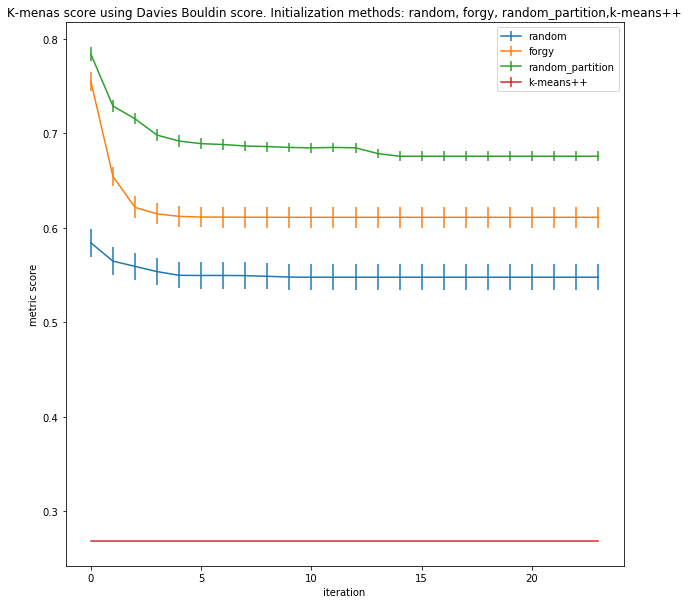

In [33]:
def plot_q_score(k_avg: dict, err_div: int = 13):
    fig = plt.figure(figsize=(10,10))
    for name, res_list in k_avg.items():
        results = np.array(res_list)
        mean = results.mean(axis=0)
        std = results.std(axis=0) / err_div
        plt.errorbar(np.arange(len(mean)), mean, std, label=name)

    plt.title("K-menas score using Davies Bouldin score. Initialization methods: random, forgy, random_partition,k-means++")
    plt.ylabel("metric score")
    plt.xlabel("iteration")
    plt.legend()
    plt.show()
    
plot_q_score(k_avg)

Następnie "psujemy zbiór", dokonując następujących zmian:
 * jeden z okręgów znacząco powiększamy
 * jeden czynimi znacząco gęściej zapełnionym
 * dwa zbliżamy mocno do siebie
 * jednemu zmieniamy kształt z okrągłego na wrzecionowaty
 * jeden znacząco oddalamy od pozostałych

Powtarzamy obliczenia dla zmodyfikowanego zbioru - jakie efekty teraz uzyskaliśmy? Jaki był stan końcowy?

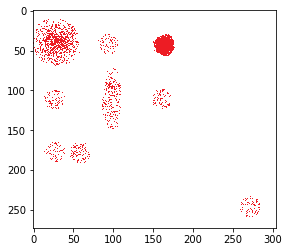

In [34]:
show_data(data[1])

In [35]:
write_data_to_csv(data[1], output_paths[1])

In [36]:
X_d = pd.read_csv(output_paths[1], sep=';', names=['x', 'y'])
X_d = np.array(X_d)

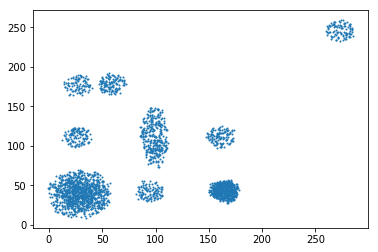

In [37]:
plt.scatter(X_d[:, 0], X_d[:, 1], s=1)
plt.show()

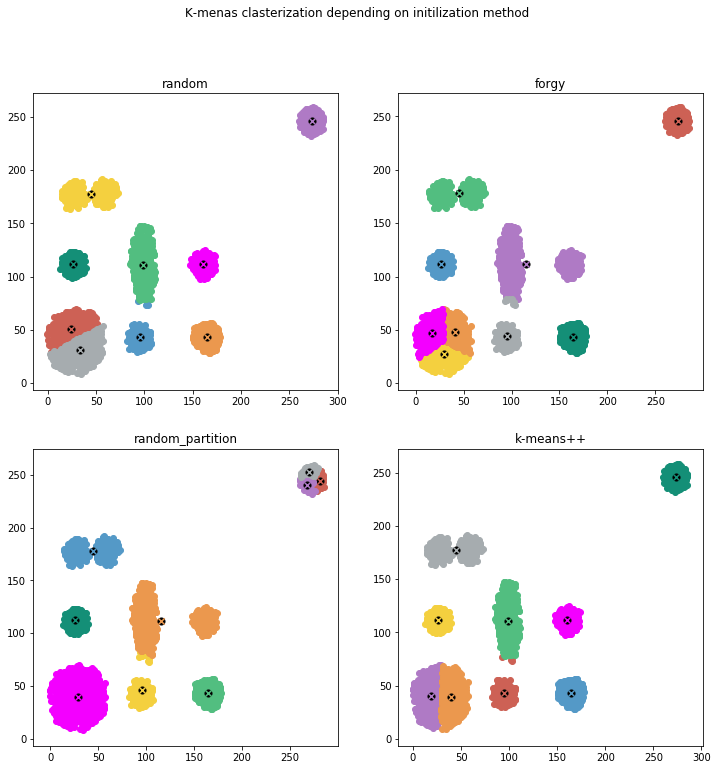

In [42]:
kmeans_dmg_result = kmeans_(X_d, init_methods)
plot_clusterization(X_d, kmeans_dmg_result, colors)

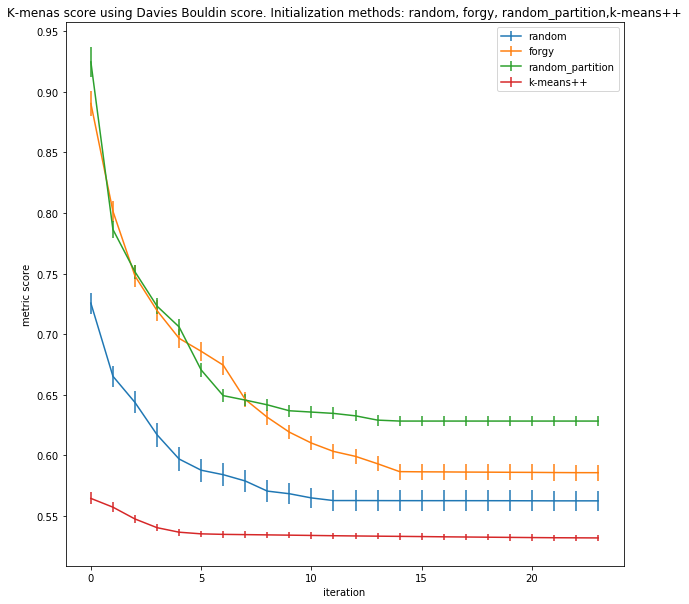

In [43]:
k_dmg_avg = kmeans_scores_avg(X_d, init_methods, 20)
plot_q_score(k_dmg_avg)

Finalnie, dla obu zbiorów (oryginalnego i "zepsutego") uruchommy dla różnych k z zakresu od 1 do 20 i porównajmy finalne metryki jakości. Czy na ich podstawie można stwierdzić, że optymalne k to 9 (bo tyle mamy klastrów)?

In [51]:
k_start, k_end = 2, 21

def get_scores(X: np.ndarray, label: str, k_start: int, k_end: int):
    return [davies_bouldin_score(
        X, KMeans(n_clusters=k, init='k-means++').fit_predict(X)) 
        for k in range(k_start, k_end)
    ]

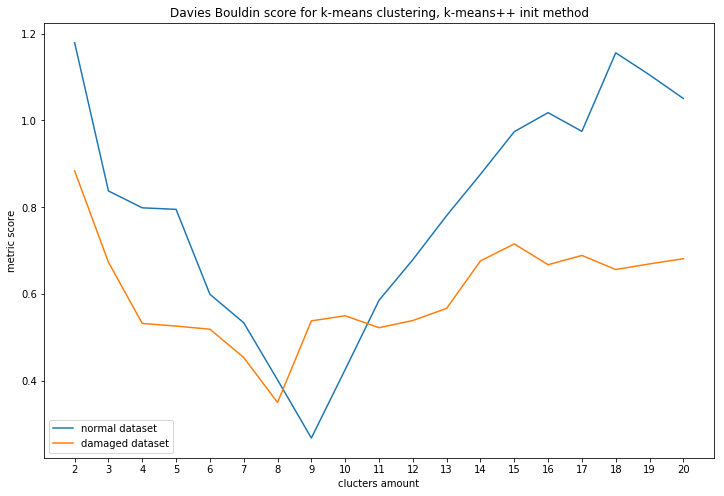

In [59]:
names = ('normal dataset', 'damaged dataset')
datasets = (X, X_d)

fig = plt.figure(figsize=(12,8))
for name, dataset in zip(names, datasets):
    y = get_scores(dataset, name, k_start, k_end)
    plt.plot(np.arange(k_start, k_end), y, label=name)
    
plt.legend()
plt.xticks(np.arange(k_start, k_end))
plt.xlabel("clucters amount")
plt.ylabel("metric score")
plt.title("Davies Bouldin score for k-means clustering, k-means++ init method")
plt.show()